# Optimization

In [1]:
import modules
import numpy as np
import importlib
importlib.reload(modules)
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def callbackF(x0):
    global obj_trend
    obj_trend.append([x0, 
                      modules.obj(x0, x_name, p), 
                      modules.ineq_constraint(x0, x_name, p),
                      modules.eq_constraint(x0, x_name, p)])
    
    
# design variables
x_name = ['x_wec','x_pen']
x_list = modules.variable_lookup(x_name)
x_list_default_values = modules.default_values(x_name)
x_list_bnds_values = modules.bnds_values(x_name)
x0 = []
x0_unit = []
x0_bnds = []
for i in range(len(x_list)):
    x0.append(x_list_default_values[x_list[i]][0])
    x0_unit.append(x_list_default_values[x_list[i]][1])
    x0_bnds.append(x_list_bnds_values[x_list[i]])

# parameters
wec_types = ['point absorber'] #['attenuator','terminator','point absorber']

# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_wec','p_fish_salmon']

default_vars = []
for i in range(len(all_vars)):
    if all_vars[i] not in x_name:
        default_vars.append(all_vars[i])

p_list = modules.variable_lookup(default_vars)
p_list_default_values = modules.default_values(default_vars)
p = {}
p_unit = []
for i in range(len(p_list)):
    p[p_list[i]] = p_list_default_values[p_list[i]][0]
    p_unit.append(p_list_default_values[p_list[i]][1])
#p = modules.default_values(default_vars)

# simulation
obj_trend = []

#optimization
opt_idx = 0
res={}
for i in range(len(wec_types)):
    p['wec_type'] = wec_types[i]
    
    arguments = (x_name, p)

    cons = ({'type': 'ineq', 'fun': modules.ineq_constraint, 'args': arguments},
            {'type': 'eq', 'fun': modules.eq_constraint, 'args': arguments})
    
    res[i] = minimize(modules.obj, x0, args=arguments, method='SLSQP', bounds=x0_bnds, constraints=cons, 
                      callback=callbackF)
    
    if res[i].fun < res[opt_idx].fun:
        opt_idx = i


col_width = len(max(x_list, key=len))
print_bold("optimal design variable:")
for i in range(len(x_list)):
    print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x0_unit[i])
print("-"*40)

print_bold("optimal objective function terms:")
cost_per_yield, price, fish_yield = modules.obj_terms(res[opt_idx].x, x_name, p)
print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')
print("-"*40)

optimal design variable:
   capture_width      32.781 [m]
   pen_diameter       24.981 [m]
   pen_height         10.187 [m]
   spacing           150.000 [m]
   stock_density      30.000 [kg/m^3]
   pen_depth          80.000 [m]
----------------------------------------
optimal objective function terms:
   cost_per_yield      0.312 [$/kg]
   price          2858850.937 [$]
   fish_yield     9166914.059 [kg]
----------------------------------------


# Plot fish growth and fish oxygen demand

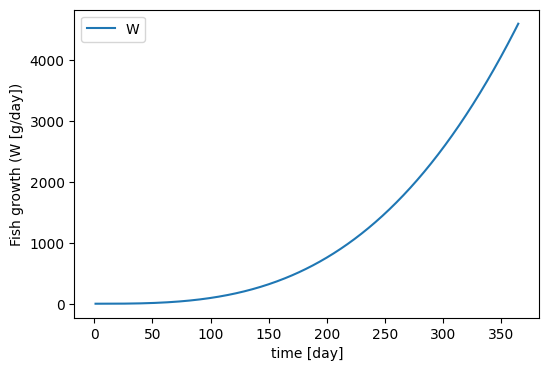

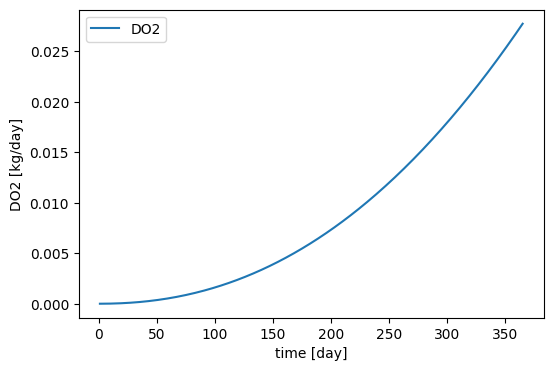

In [2]:
x_opt = res[opt_idx].x
modules.plot_variable(x_opt, x_name, p)

# Plot objective function and constraints

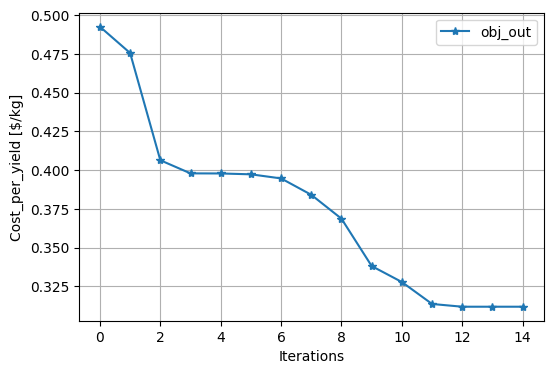

In [3]:
total_iter = len(obj_trend)
obj_out = np.zeros(total_iter)
obj_ineq_const = np.zeros([total_iter,len(obj_trend[0][2])])
for i in range(total_iter):
    obj_out[i] = obj_trend[i][1]
    obj_ineq_const[i] = obj_trend[i][2]
    
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(obj_out, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)

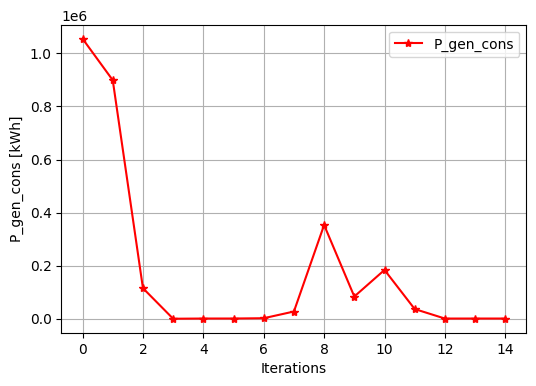

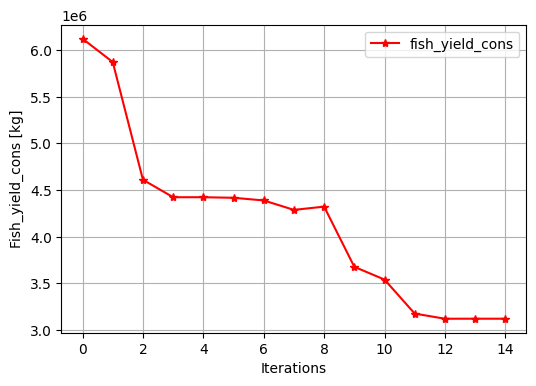

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(obj_ineq_const[:,0], 'r', label='P_gen_cons', marker='*')
ax.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax.legend()
ax.grid(True)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(obj_ineq_const[:,1], 'r', label='fish_yield_cons', marker='*')
ax.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax.legend()
ax.grid(True)

# Plot fitness 